In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- KoBert 모델 받기

In [ ]:
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install gluonnlp
!pip install mxnet
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=664994 sha256=b374b6fd47c55131f7b5f6e712ab5272e2912bdbea9a1aa765412

- Mecab 받기

In [ ]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# !bash install_mecab-ko_on_colab_light_220429.sh

# data preprocessing

In [ ]:
# data directory
%cd /content/drive/Othercomputers/내 컴퓨터/GitHub/자연어 처리/명품 커머스 플렛폼 분석/Bert-VOC_e-commerce

/content/drive/Othercomputers/내 컴퓨터/GitHub/자연어 처리/명품 커머스 플렛폼 분석/Bert-VOC_e-commerce


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gluonnlp as nlp
from konlpy.tag import Mecab

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from datetime import datetime
from kobert_tokenizer import KoBERTTokenizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import utils
from utils import save_model, load_model, c_load_model, calc_accuracy, softmax
from model import BERTDataset, BERTClassifier, c_BERTClassifier, EarlyStopping, senti_predict, category_predict
from preprocessing import get_reviews, get_preprocessing_reviews

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

- 긍/부정

In [2]:
import pandas as pd
from preprocessing import get_reviews, get_preprocessing_reviews
data_dir = './data/'

In [3]:
senti_data, cate_data, data = get_preprocessing_reviews(data_dir)

In [4]:
senti_data

[['월일에 주문에서 월일에 재고가 없어 환불처리 됐다고 통보하네요', 0],
 ['어이가없어서 여기 믿고 물건 구매해서 안심하고 기다리다 뒤통수 맞고 다시 물건 찾는일 없도록 이용하지마세요', 0],
 ['기다려도 물건 안와요', 0],
 ['여기 상품반품비로 먹고사는 업체인것같습니다', 0],
 ['나쁜놈들', 0],
 ['가격이 넘 착해요', 1],
 ['귀찮아서 리뷰 안 남기는데 너무 만족하고 잘 쓰고 있어요', 1],
 [' 후기보는 재미도 있고요 후기보다가 급 지름신와서 텅장을 부여잡은게 한두번이 아니네요', 1],
 ['지금도 제품 많지만 더 이쁘고 좋은거 마니 들어오면 좋겠어요', 1],
 ['검색하다가 광고가 눈에 띄어 들어오게 되었는데 매장가보다 저렴하고', 1],
 ['배송도 빠르게 와서 유용하게 잘 쓰고 있습니다', 1],
 ['상품과 배송 모두 만족입니다', 1],
 ['몽클 패딩 저렴하게 구입했습니다', 1],
 ['추천추천', 1],
 ['명품 쇼핑할때마다 너무 잘 쓰고 있어요', 1],
 ['특히 오늘 배송상품 마음에 듭니다', 1],
 ['알람설정해놓고 이벤트 참여하고 구경하는 것도 은근 재미있네요ㅋㅋ 랭킹메뉴도 자주 보는데 요즘 많이 사는 제품들 볼 수있어서 구매에도 도움이 됩니다',
  1],
 ['알람설정해놓고 이벤트 참여하고 구경하는 것도 은근 재미있네요ㅋㅋ 랭킹메뉴도 자주 보는데 요즘 많이 사는 제품들 볼 수있어서 구매에도 도움이 됩니다',
  1],
 ['좋은 앱 감사', 1],
 ['다양한 브랜드를 한번에 볼수 있어서 편리해요', 1],
 ['다양한 브랜드를 한번에 볼수 있어서 편리해요', 1],
 ['카테고리 구분이나 필터 기능 잘 되있고', 1],
 ['이벤트 많아 좋네요', 1],
 ['편해요', 1],
 ['제가 가장 많이 들어가는 앱 탑쓰리에요', 1],
 ['저렴하게 세일이벤트나 쿠폰 받으면 평소보다 싸게 살 수 있으니 매일 안 볼수가 없네요', 1],
 ['혜수언니가 모델이라 더 좋음', 1],
 ['제품

In [5]:
cate_data

[['월일에 주문에서 월일에 재고가 없어 환불처리 됐다고 통보하네요', 2],
 ['어이가없어서 여기 믿고 물건 구매해서 안심하고 기다리다 뒤통수 맞고 다시 물건 찾는일 없도록 이용하지마세요', 7],
 ['기다려도 물건 안와요', 0],
 ['여기 상품반품비로 먹고사는 업체인것같습니다', 0],
 ['나쁜놈들', 8],
 ['가격이 넘 착해요', 5],
 ['귀찮아서 리뷰 안 남기는데 너무 만족하고 잘 쓰고 있어요', 8],
 [' 후기보는 재미도 있고요 후기보다가 급 지름신와서 텅장을 부여잡은게 한두번이 아니네요', 9],
 ['지금도 제품 많지만 더 이쁘고 좋은거 마니 들어오면 좋겠어요', 3],
 ['검색하다가 광고가 눈에 띄어 들어오게 되었는데 매장가보다 저렴하고', 5],
 ['배송도 빠르게 와서 유용하게 잘 쓰고 있습니다', 0],
 ['상품과 배송 모두 만족입니다', 0],
 ['몽클 패딩 저렴하게 구입했습니다', 5],
 ['추천추천', 8],
 ['명품 쇼핑할때마다 너무 잘 쓰고 있어요', 8],
 ['특히 오늘 배송상품 마음에 듭니다', 6],
 ['알람설정해놓고 이벤트 참여하고 구경하는 것도 은근 재미있네요ㅋㅋ 랭킹메뉴도 자주 보는데 요즘 많이 사는 제품들 볼 수있어서 구매에도 도움이 됩니다',
  1],
 ['알람설정해놓고 이벤트 참여하고 구경하는 것도 은근 재미있네요ㅋㅋ 랭킹메뉴도 자주 보는데 요즘 많이 사는 제품들 볼 수있어서 구매에도 도움이 됩니다',
  3],
 ['좋은 앱 감사', 8],
 ['다양한 브랜드를 한번에 볼수 있어서 편리해요', 1],
 ['다양한 브랜드를 한번에 볼수 있어서 편리해요', 3],
 ['카테고리 구분이나 필터 기능 잘 되있고', 1],
 ['이벤트 많아 좋네요', 5],
 ['편해요', 1],
 ['제가 가장 많이 들어가는 앱 탑쓰리에요', 8],
 ['저렴하게 세일이벤트나 쿠폰 받으면 평소보다 싸게 살 수 있으니 매일 안 볼수가 없네요', 5],
 ['혜수언니가 모델이라 더 좋음', 8],
 ['제품

In [6]:
data.head()

,platform,store,date,review,rating,category,label,cate_label
0,trenbe,apple,2023-02-02,월일에 주문에서 월일에 재고가 없어 환불처리 됐다고 통보하네요,1.0,고객센터,0,2
1,trenbe,apple,2023-02-02,어이가없어서 여기 믿고 물건 구매해서 안심하고 기다리다 뒤통수 맞고 다시 물건 찾는...,1.0,정품 안전성,0,7
2,trenbe,apple,2023-02-02,기다려도 물건 안와요,1.0,배송,0,0
3,trenbe,google,2023-02-01,여기 상품반품비로 먹고사는 업체인것같습니다,1.0,배송,0,0
4,trenbe,google,2023-02-01,나쁜놈들,1.0,만족도&기타,0,8


In [7]:
data['label'].unique(), len(data)

(array([0, 1], dtype=int64), 12644)

In [8]:
data.groupby('label').size().reset_index(name='count')

,label,count
0,0,2471
1,1,10173


<AxesSubplot:>

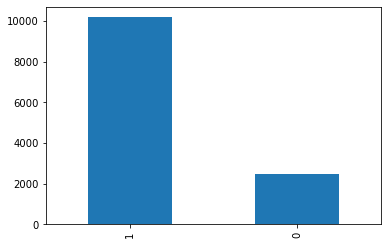

In [12]:
data['label'].value_counts().plot(kind='bar')

- category

In [9]:
data['cate_label'].unique(), len(data['cate_label'].unique())

(array([2, 7, 0, 8, 5, 9, 3, 6, 1, 4], dtype=int64), 10)

In [10]:
data.groupby('cate_label').size().reset_index(name='count')

,cate_label,count
0,0,1030
1,1,1524
2,2,755
3,3,1432
4,4,738
5,5,2299
6,6,318
7,7,1137
8,8,3222
9,9,189


<AxesSubplot:>

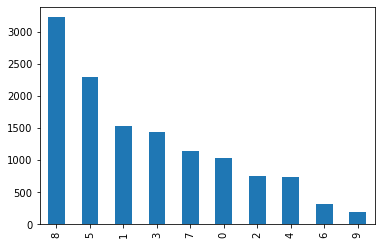

In [11]:
data['cate_label'].value_counts().plot(kind='bar')

### max length 확인

In [ ]:
mecab = Mecab()
max_len = []
for sentence in data['review']:
    max_len.append(len(mecab.morphs(sentence)))

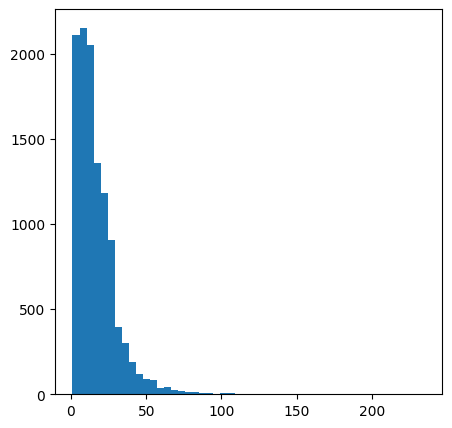

In [ ]:
# max_len = 128
plt.figure(figsize=(5, 5))
plt.hist(max_len, bins=50)
plt.show()

# training

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


## 긍/부정

In [ ]:
# 긍/부정
num_classes = 2
senti_dataset_train, senti_dataset_test = train_test_split(senti_data, test_size = 0.2, shuffle = True, random_state = 29)

In [ ]:
patience = 5
max_len = 128
batch_size = 100
warmup_ratio = 0.1
num_epochs = 30
max_grad_norm = 1
log_interval = 200
learning_rate =  0.0001
dr_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
tok = tokenizer.tokenize

senti_data_train = BERTDataset(senti_dataset_train, 0, 1, tok, vocab, max_len, True, False)
senti_data_test = BERTDataset(senti_dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
# train 토큰 최대 길이
to_len = [senti_data_train[idx][1].astype(int) for idx in range(len(senti_data_train))]
max(to_len)

array(128)

In [ ]:
# test 토큰 최대 길이
to_len = [senti_data_test[idx][1].astype(int) for idx in range(len(senti_data_test))]
max(to_len)

array(128)

In [ ]:
senti_train_dataloader = torch.utils.data.DataLoader(senti_data_train, batch_size = batch_size, num_workers = 5)
senti_test_dataloader = torch.utils.data.DataLoader(senti_data_test, batch_size = batch_size, num_workers = 5)

In [ ]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=dr_rate).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(senti_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


- 학습


In [ ]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(senti_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        t_acc = (train_acc / (batch_id+1))
        # train_accuracies.append(t_acc)
        # train_losses.append(loss.item())
        print(f'Epoch: {epoch}/{num_epochs}\t| Train Acc: {t_acc:.4f}\t| Train Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(senti_test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)

            out = model(token_ids, valid_length, segment_ids)
            val_loss = loss_fn(out, label)
            val_acc += calc_accuracy(out, label)

            v_acc = (val_acc / (batch_id+1))
            # val_accuracies.append(v_acc)
            # val_losses.append(val_loss.item())
            print(f'Epoch: {epoch}/{num_epochs}\t| Val Acc: {v_acc:.4f}\t| Val Loss: {val_loss.item():.4f}')

    train_accuracies.append(t_acc)
    train_losses.append(loss.item())
    val_accuracies.append(v_acc)
    val_losses.append(val_loss.item())
    print(f'EPOCHS: {epoch+1}/{num_epochs}\t| train acc: {t_acc}\t| train loss: {loss.item()}\t| val acc: {v_acc}\t| val loss: {val_loss.item()}')


    # epoch 당 save
    if (epoch+1) % 5 == 0:
        save_model(model.state_dict(), f'senti_model_{epoch+1}.pth')

save_model(model.state_dict(), f'e20_b50_d05_lr0001_senti_model_{epoch+1}.pth')

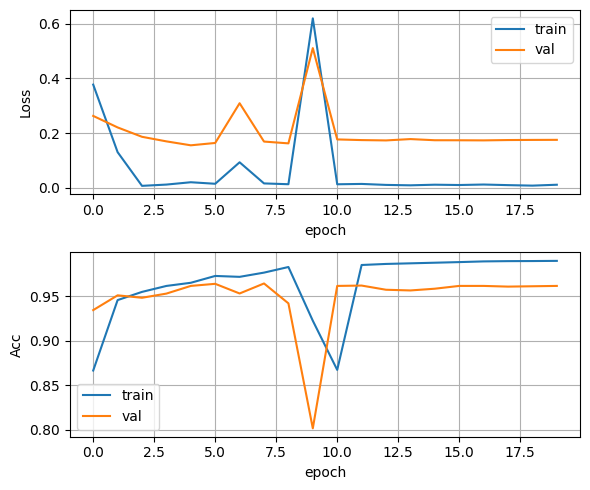

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid('on')
plt.legend()

plt.subplot(212)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

## category


In [ ]:
patience = 10
max_len = 128
batch_size = 100 ## 256 - 512 (total : 14,000)
warmup_ratio = 0.1
num_epochs = 30 ## 30 - 100
max_grad_norm = 1
log_interval = 200
learning_rate =  0.0001 ## 0.001 -  0.001 / 0.0005 / 0.00001
dr_rate = 0.55    ## 0.5 or 0.45
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# category
num_classes = 10
category_dataset_train, category_dataset_test = train_test_split(cate_data, test_size = 0.2, shuffle = True, random_state = 29)

In [ ]:
tok = tokenizer.tokenize

category_data_train = BERTDataset(category_dataset_train, 0, 1, tok, vocab, max_len, True, False)
category_data_test = BERTDataset(category_dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
category_train_dataloader = torch.utils.data.DataLoader(category_data_train, batch_size = batch_size, num_workers=5)
category_test_dataloader = torch.utils.data.DataLoader(category_data_test, batch_size = batch_size, num_workers=5)

In [ ]:
c_model = c_BERTClassifier(bertmodel, dr_rate=dr_rate).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in c_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in c_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()

t_total = len(category_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

- 학습


In [ ]:
c_train_accuracies = []
c_train_losses = []
c_val_accuracies = []
c_val_losses = []

for epoch in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0

    c_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(category_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = c_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(c_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)

        t_acc = (train_acc / (batch_id+1))
        # train_accuracies.append(t_acc)
        # train_losses.append(loss.item())
        print(f'Epoch: {epoch}/{num_epochs}\t| Train Acc: {t_acc:.4f}\t| Train Loss: {loss.item():.4f}')

    c_model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(category_test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)

            out = c_model(token_ids, valid_length, segment_ids)
            val_loss = loss_fn(out, label)
            val_acc += calc_accuracy(out, label)

            v_acc = (val_acc / (batch_id+1))
            # val_accuracies.append(v_acc)
            # val_losses.append(val_loss.item())
            print(f'Epoch: {epoch}/{num_epochs}\t| Val Acc: {v_acc:.4f}\t| Val Loss: {val_loss.item():.4f}')

    c_train_accuracies.append(t_acc)
    c_train_losses.append(loss.item())
    c_val_accuracies.append(v_acc)
    c_val_losses.append(val_loss.item())
    print(f'EPOCHS: {epoch+1}/{num_epochs}\t| train acc: {t_acc}\t| train loss: {loss.item()}\t| val acc: {v_acc}\t| val loss: {val_loss.item()}')


    # epoch 당 save
    if (epoch+1) % 5 == 0:
        save_model(c_model.state_dict(), f'cls8_e30_b100_d055_lr0001_category_model_{epoch+1}.pth')

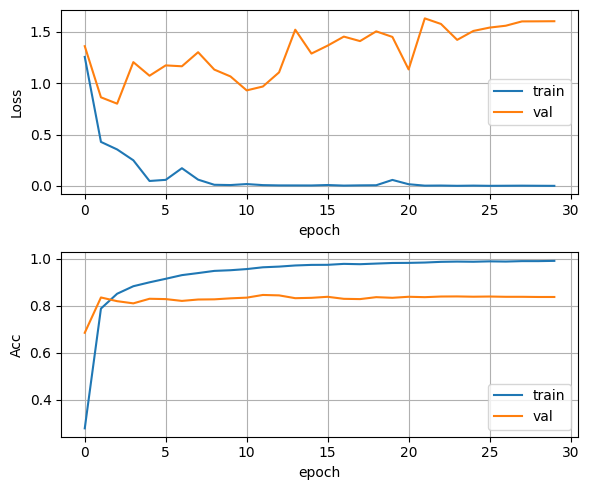

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(c_train_losses, label='train')
plt.plot(c_val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid('on')
plt.legend()

plt.subplot(212)
plt.plot(c_train_accuracies, label='train')
plt.plot(c_val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

## Testing

- 긍/부정

In [ ]:
os.listdir('trained_model/')

In [ ]:
senti_ckpt_path = '경로+모델이름.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE
senti_model = load_model(senti_ckpt_path, DEVICE)
senti_model

model state:  <All keys matched successfully>


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

- category

In [ ]:
category_ckpt_path = '경로+모델이름.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE
category_model = c_load_model(category_ckpt_path, DEVICE)
category_model

model state:  <All keys matched successfully>


c_BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

- 긍/부정


In [99]:
def senti_predict(mode, predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval = []
        i = out[0]
        logits = i.detach().cpu().numpy()
        logits = softmax(logits)
        output = np.argmax(logits)
        text = ''

        if output == 0:
            text = '부정'

        else:
            text = '긍정'

    return text

In [100]:
CATE_TO_NUM = {
    '배송':0,
    'UX/UI 편의성':1,
    '고객센터':2,
    '상품 구색':3,
    '앱 오류':4,
    '가격&프로모션':5,
    '상품 품질':6,
    '정품 안전성':7,
    '만족도&기타':8,
    '상품 설명':9
}

NUM_TO_CATE = {
    0:'배송',
    1:'UX/UI 편의성',
    2:'고객센터',
    3:'상품 구색',
    4:'앱 오류',
    5:'가격&프로모션',
    6:'상품 품질',
    7:'정품 안전성',
    8:'만족도&기타',
    9:'상품 설명'
}

In [103]:
def category_predict(model, predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval = []
        i = out[0]
        logits = i.detach().cpu().numpy()
        logits = softmax(logits)
        output = np.argmax(logits)
        text = ''

        if output == 0:
            text = '배송'
        elif output == 1:
            text = 'UX/UI 편의성'
        elif output == 2:
            text = '고객센터'
        elif output == 3:
            text = '상품 구색'
        elif output == 4:
            text = '앱 오류'
        elif output == 5:
            text = '가격&프로모션'
        elif output == 6:
            text = '상품 품질'
        elif output == 7:
            text = '정품 안정성'
        elif output == 8:
            text = '만족도&기타'
        elif output == 9:
            text = '상품 설명'


    return text

In [107]:
index = 300
sentence = senti_data[index][0]

print('review: ', sentence)
c_text = category_predict(category_model, sentence)
s_text = senti_predict(senti_model, sentence)
print(c_text, '에 대한 ', s_text, '리뷰입니다.')

review:  타임딜 되게 맘에 들어요 가격 진짜 저렴하게 잘 살 수 있어요 ㅠㅠ 잘 누려보세요
가격&프로모션 에 대한  긍정 리뷰입니다.
